### Ustawienie ziarna

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 0 #@param {type: "integer"}
np.random.seed(seed)

## Funkcje celu

## Wybór parametrów

### Wybór funkcji celu

In [0]:
#@title funkcja celu { run: "auto" }

config = "constant" #@param ["constant", "Gaussian function", "sum of two Gaussian functions", "rastrigin"]

### Wybór funkcji celu i parametrów (mu, sigma dla funkcji Gaussa i A dla funkcji Rastrigina)

In [0]:
A = 10 #@param {type: "integer"}
mu1 = 0 #@param {type: "integer"}
sigma1 = 1 #@param {type: "integer"}
mu2 = 0 #@param {type: "integer"}
sigma2 = 1 #@param {type: "integer"}

def constant(x):
    return 1

def gaussian(x):
    return np.sum(np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sigma1, 2.))))

def two_gaussians(x):
    return gaussian(x, mu1, sigma1) + gaussian(x, mu2, sigma2)

def rastrigin(x):
    n = x.shape[0]
    return A*n + np.sum(x - A * np.cos(2 * np.pi * x))


if config == "constant":
    goal_function = constant
elif config == "rastrigin":
    goal_function = rastrigin
elif config == "sum of two Gaussian functions":
    goal_function = two_gaussians
else:
    goal_function = gaussian

### Parametry populacji

In [0]:
rozmiar_populacji = 1000 #@param {type: "integer"}
wymiar_populacji = 2 #@param {type: "integer"}

### Parametry algorytmu

In [0]:
dolna_granica = -100 #@param {type: "integer"}
gorna_granica = 100 #@param {type: "integer"}
parametr_mutacji = 1 #@param {type: "integer"}
rozmiar_turnieju = 4 #@param {type: "integer"}
p_krzyzowania = 0.5 #@param {type: "number"}
liczba_iteracji =  10#@param {type: "integer"}

## Algorytm ewolucyjny

In [0]:
class EvolutionaryAlgorithm:
    def __init__(self, goal_function):
        self.LowerBound = dolna_granica
        self.UpperBound = gorna_granica

        self.populationSize = rozmiar_populacji
        self.dim = wymiar_populacji

        self.mutation_sigma = parametr_mutacji
        self.tournament_size = rozmiar_turnieju

        # change according to settings
        self.evaluate = goal_function
       
        # self.sigma = settings.sigma
        self.population = 10 * (np.random.rand(self.populationSize, self.dim) - 0.5)

        self.crossing_probability = p_krzyzowania

        self.iterations = liczba_iteracji

        self.iter = 0  # current number of iteration
        self.mutation_success_counter = 0

        

    def Solve(self):
        for self.iter in range(self.iterations):
            print("iteration: ", self.iter)

            # Analyze clusters in Population            
            self.AnalyzePopulation()

            # The population is evaluated (selection). The best adapted individuals take part in the reproduction process
            self.Reproduction()

            self.Crossover()
            self.Mutate()

            self.Succession()




    def AnalyzePopulation(self):
        print("mean", np.mean(self.population, axis = 0))
        print("std", np.std(self.population, axis = 0))



    def Reproduction(self):
        fitness = np.apply_along_axis(self.evaluate, 1, self.population).flatten()
        tmpPopulation = np.zeros(shape = self.population.shape)

        for i in range(self.populationSize):
            tournamentIndices = np.random.randint(self.populationSize, size = self.tournament_size)
            tmpfitness = np.zeros(shape = fitness.shape)
            tmpfitness[tournamentIndices] = fitness[tournamentIndices]
            
            tmpPopulation[i] = self.population[np.argmax(tmpfitness)]

        self.population = tmpPopulation.copy()


    def Mutate(self):
        mean_value_before = np.mean(np.apply_along_axis(self.evaluate, 1, self.population))
        self.population = self.population + self.mutation_sigma * np.random.normal(size = self.population.shape)
        mean_value_after = np.mean(np.apply_along_axis(self.evaluate, 1, self.population))

        if mean_value_after > mean_value_before:
            self.mutation_success_counter += 1

        if self.mutation_success_counter > 0.2 * self.iter:
            self.mutation_sigma *= 2.0
        else:    
            self.mutation_sigma /= 2.0





    def Crossover(self):
        number_of_crossovers = int(self.crossing_probability * self.populationSize)
            
        # In each crossover, we select two parents
        # parents are deleted from population, their child is added to population
        # this phase SHRINKS population, population will regain its original size on succession

        rows_to_delete = []
        children = np.zeros(shape = (number_of_crossovers, self.population.shape[1]))

        for i in range(number_of_crossovers):
            first_parent_ind = np.random.randint(self.populationSize)
            second_parent_ind = np.random.randint(self.populationSize)

            rows_to_delete.append(first_parent_ind)
            rows_to_delete.append(second_parent_ind)

            child = (self.population[first_parent_ind] + self.population[second_parent_ind]) / 2
            children[i] = child


        self.population = np.delete(self.population, rows_to_delete, axis = 0)
        self.population = np.append(self.population, children, axis = 0)


    def Succession(self):
        # generative succession - we are taking elements after mutation
        # we keep population size constant, that's why we are duplicatind some elements sometimes
        add_individuals = np.random.choice(self.population.shape[0], self.populationSize - self.population.shape[0])
        self.population = np.append(self.population, self.population[add_individuals], axis = 0)


## Statystyka Gap

In [0]:
def gap_stat(data, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return resultsdf

## Wizualizacja populacji przed uruchomieniem algorytmu

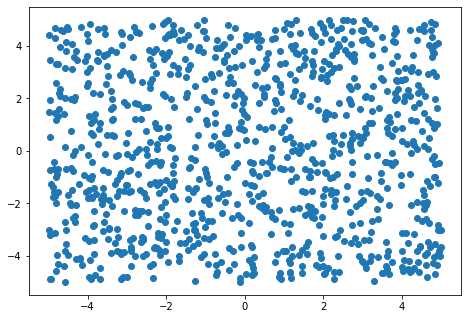

In [7]:
alg = EvolutionaryAlgorithm(goal_function = constant)

x = []
y = []
for obs in alg.population:
    x.append(obs[0])
    y.append(obs[1])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(x, y)

## Uruchomienie algorytmu

In [8]:
alg.Solve()

x2 = []
y2 = []
for obs in alg.population:
    x2.append(obs[0])
    y2.append(obs[1])

iteration:  0
mean [0.03236498 0.04035023]
std [2.93668516 2.96143884]
iteration:  1
mean [ 0.02684862 -0.1002774 ]
std [2.60625878 2.68706435]
iteration:  2
mean [-0.11333428 -0.23224106]
std [2.44579357 2.58871881]
iteration:  3
mean [ 0.1926501  -0.44191726]
std [2.45876272 2.43006522]
iteration:  4
mean [ 0.15817294 -0.46482883]
std [2.30402866 2.22172162]
iteration:  5
mean [ 0.09454075 -0.45976813]
std [2.19330256 2.05328121]
iteration:  6
mean [ 0.14161841 -0.41580206]
std [2.11100356 1.90097188]
iteration:  7
mean [ 0.37208855 -0.36048544]
std [2.1582999  1.89700203]
iteration:  8
mean [ 0.65841465 -0.45737616]
std [1.98225642 1.92391681]
iteration:  9
mean [ 0.63909492 -0.33212407]
std [1.80310747 1.77188557]


In [12]:
df = pd.DataFrame()
df['x'] = x2
df['y'] = y2
print(df)

            x         y
0   -0.969910 -0.721935
1    0.458919 -2.969689
2    1.479315 -2.252450
3    1.721797  1.294805
4   -0.426172  2.396660
..        ...       ...
995  0.318825 -1.048281
996 -0.761940 -0.392446
997 -0.807791 -1.247295
998  3.913438 -1.586681
999  2.725615 -0.612766

[1000 rows x 2 columns]


## Wybór K - optymalnej liczby klastrów

### Wskazanie optymalnego K za pomocą Elbow Method

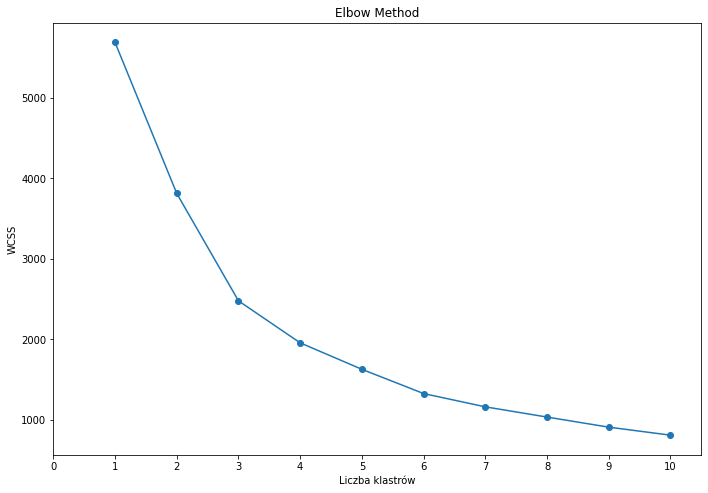

In [50]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.set_xticks(np.arange(0,12,1))
ax.set_xlim(0,10.5)
plt.plot(range(1, 11), wcss, '-o')
plt.title('Elbow Method')
plt.xlabel('Liczba klastrów')
plt.ylabel('WCSS')
plt.show()

### Wskazanie optymalnego K za pomocą Gap statistic

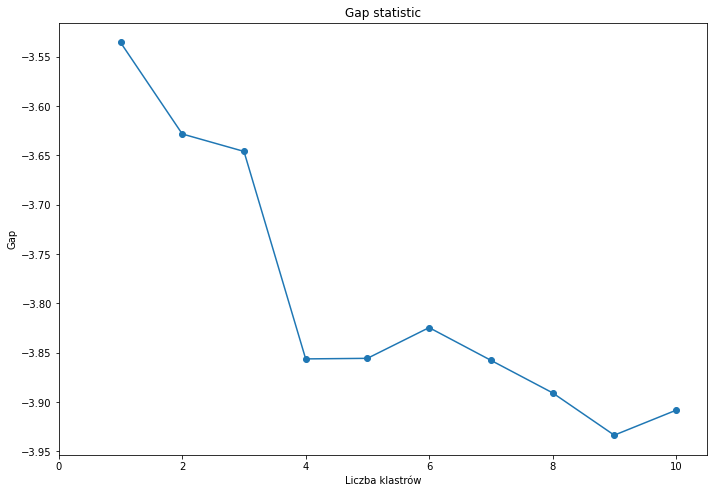

In [52]:
gap_df = gap_stat(df, nrefs=5, maxClusters=11)

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.set_xticks(np.arange(0,12,2))
ax.set_xlim(0,10.5)
plt.plot(gap_df.clusterCount, gap_df.gap, '-o')
plt.title('Gap statistic')
plt.xlabel('Liczba klastrów')
plt.ylabel('Gap')
plt.show()

## Wyznaczenie klastrów i centroidów

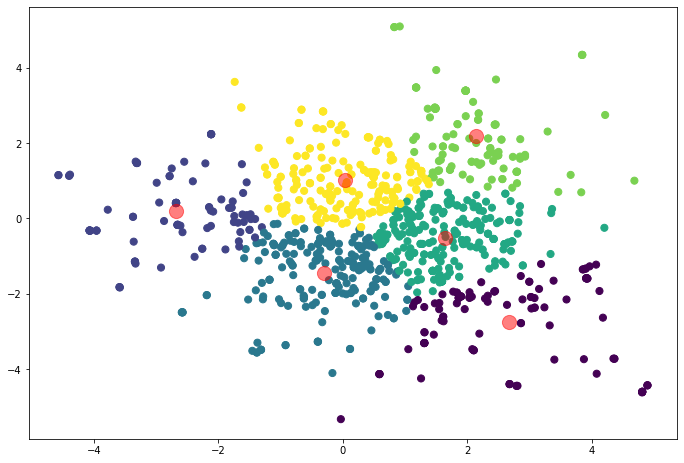

In [41]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
plt.scatter(df['x'], df['y'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);